# **AI61002 DLFA**
# **COVID-19 Action Radiology CXR Project**
##    **-Divyanshu Sheth, 18QE30008**

An AlexNet model, pretrained on ImageNet, has been used for this project. The final test accuracy obtained is 93.0769%, with the final F1-score on the test set being 0.91. The model was trained over 77 epochs over the dataset, which had 881 images with their corresponding ground-truth labels. 
<br>
The dataset used was composed of data from sources 1, 2, 3, 5, 6, and 7. Limited data was taken from Source-3 because of issues with internet connection and the large size of the file. On working on Google Colab, the downloaded zip always turned out to be corrupteed and only a few images could be extracted from the dataset. Source-4 wasn't used because of problems with the download- the actual number of downloaded images were far less in number than the amount specified on the Kaggle website. Also, file names provided in the csv for Source-4 were different from the file names of images downloaded. <br> The dataset was spilt as follows: **72.5% train set, 12.7% validation set and 14.7% test set**. This amounts to 639 images for training, 112 images for validation and 130 for testing.

1. 
>Yes:
i) A **manual rescaling weight** has been given to each class while defining the **loss function**. This ensures that the model will be largely penalised for wrong classifications according to the corresponding prevalance of the class in the dataset. Classifying images belonging to the minority class incorrectly results in higher penalty. The **weights assigned to the classes are the inverse of their corresponding image counts** in the dataset.
ii) **F1-score** has been chosen as the **primary evaluation metric**. The model was trained until a favourable outcome for F1-score on validation data was observed. Also, results on the test set have been presented as F1-score values along with accuracy values.

2. >Yes, **Cosine Annealing with Warm Restarts** has been incorporated in the model. The optimizer is Adaptive Momentum (Adam), recently made compatible with warm restarts.

3. >Training and validation curves have been **plotted towards the end of the notebook**. For deciding on when to stop training the model, it was **run over 150 epochs**, taking **validation results on after every epoch**; what was observed was that training and validation accuracy curves reach saturation and then the validation curve (based on F1-score and accuracy) starts slightly dipping after about 77 epochs of training. Thus, when the **validation loss** was observed to be **minimum**, at the 77th epoch, i.e. maximum validation accuracy/F1-score, training was stopped.

4. >The total number of **parameters** in the model is **58293632**. <br><br>
Breakup: <br>
conv1 -> 227 x 227 x 3 -> 55 x 55 x 96 -> 34944 <br>
maxpool1 -> 0 <br>
conv2 -> 27 x 27 x 96 -> 27 x 27 x 256 -> 614656 <br>
maxpool2 -> 0 <br>
conv3 -> 13 x 13 x 256 -> 13 x 13 x 384 -> 885120 <br>
conv4 -> 13 x 13 x 384 -> 13 x 13 x 384 -> 1327488 <br>
conv5 -> 13 x 13 x 384 -> 13 x 13 x 256 -> 884992 <br>
maxpool5 -> 0 <br>
fc6 -> 9216 - 4096 -> 37752832 <br>
fc7 -> 4096 - 4096 -> 16781312 <br>
fc8 -> 4096 - 3 -> 12288 <br>
Total = 58293632 parameters
<br><br>
>No. of **Floating Point Operations** is **1,424,001,024 FLOPs** or approx. 1.42 GFLOPs.  <br><br>Breakup:<br>
  [[Conv1, 140940800], <br>
  [Relu1, 774400], <br>
  [MaxPool1, 746496], <br>
  [Conv2', 447897600],<br>
  [Relu2, 559872],<br>
  [MaxPool2, 519168],<br>
  [Conv3, 224280576],<br>
  [Relu3, 259584],<br>
  [Conv4, 299040768],<br>
  [Relu4, 173056],<br>
  [Conv5, 199360512],<br>
  [Relu5, 173056],<br>
  [MaxPool3, 147456],<br>
  [AveragePool1, 18432],<br>
  [Gemm1, 75497472],<br>
  [Relu6, 16384],<br>
  [Gemm2, 33554432],<br>
  [Relu7, 16384],<br>
  [Gemm3, 24576]])<br>
  Total = 1,424,001,024 FLOPs

  >The **space** taken up by the model is **228,067,437 bytes (218 MB)**. 



In [0]:
# Please change **train_csv_file** and **test_csv_file** to the file locations of the csv file containing ground-truth labels for the train images and
# test images respectively, 
# and **root_dir** to the location of the folder containing **all images** in the dataset *directly* in it (*without* subfolders) 

# train_csv_file = '/content/drive/My Drive/AI Work/COVID-19 Action Radiology CXR Project/datasets/ALL_CSVS/Copy of UPDATED_TRAIN_1 - UPDATED_TRAIN_1.csv'
# test_csv_file = '/content/drive/My Drive/AI Work/COVID-19 Action Radiology CXR Project/datasets/ALL_CSVS/UPDATED_TEST_1.csv'
# root_dir = '/content/drive/My Drive/AI Work/COVID-19 Action Radiology CXR Project/datasets/NO_CHEXPERT_IMAGES'

train_csv_file = '/content/drive/My Drive/AI Work/COVID-19 Action Radiology CXR Project/datasets/ALL_CSVS/ultra_final_train.csv'
test_csv_file = '/content/drive/My Drive/AI Work/COVID-19 Action Radiology CXR Project/datasets/ALL_CSVS/ultra_final_test.csv'
root_dir = '/content/drive/My Drive/AI Work/COVID-19 Action Radiology CXR Project/datasets/NO_CHEXPERT_IMAGES'

In [17]:
# Imports for essential libraries:

%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io as io
from sklearn.metrics import f1_score
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

torch.manual_seed(42) # Testing accuracy = 84.61538461538461 | F1-Score = 0.3333333333333333

In [0]:
# Images are resized to 224 x 224 before passing in the model. 
# Data Augmentation has been done - random rotations by +/- 10 degrees, 
# as the original images were themselves found to vary in alignment from the vertical by small angles.
# Also, images have been normalized to enable better convergence while training.

data_transform = transforms.Compose([transforms.Resize((224, 224)),
                                     transforms.RandomRotation(degrees=(-10, 10)),
                                     transforms.ToTensor(), 
                                     transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

In [0]:
# The class for the dataset is defined here. 
# __len__ returns the length of the dataset and __getitem__ returns an image and its corresponding label.

class COVID19_Dataset(Dataset):
  
  def __init__(self, csv_file, root_dir, train, transform = data_transform):
    self.csv_file = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform
    self.train = train

  def __len__(self):
    return len(self.csv_file)
  
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    file_name = self.csv_file.iloc[idx, 0]
    
    if self.csv_file.iloc[idx, 1] == 'Source-3':   # For source 3, image names in the csv file had train_reshape or valid_reshape before  
      file_name = file_name[14:]                   # the actual image name, so this gets the original image name from the csv names.
    image = Image.open(os.path.join(self.root_dir, file_name)).convert('RGB')
    disease_vector = [self.csv_file.iloc[idx, 3:]] if self.train == True else [self.csv_file.iloc[idx, 2:]]
    tensor_disease_vector = torch.Tensor(disease_vector)
    numbered_result = torch.argmax(tensor_disease_vector)

    if self.transform:
      image = self.transform(image)
    return (image, numbered_result)

In [0]:
# Images with uncertain labels are dropped from the dataset. New csv files are created which does not contain these images.

drop_list = []
df = pd.read_csv(train_csv_file)
length = len(df)
for i in range(1, length):
  if df.iloc[i, 3]  == -1 or df.iloc[i, 4] == -1 or df.iloc[i, 5] == -1:
    drop_list.append(i)
df.drop(df.index[drop_list], inplace = True)
df.to_csv(r'train_combined_updated.csv', index = False)  # New csv file for the train set

drop_list = []
df = pd.read_csv(test_csv_file)
length = len(df)
for i in range(1, length):
  if df.iloc[i, 2]  == -1 or df.iloc[i, 3] == -1 or df.iloc[i, 4] == -1:
    drop_list.append(i)
df.drop(df.index[drop_list], inplace = True)
df.to_csv(r'test_combined_updated.csv', index = False)   # New csv file for the test set

In [0]:
# We define and build the datasets and DataLoaders for training, validation and test sets.

trainval_dataset = COVID19_Dataset(csv_file = 'train_combined_updated.csv', root_dir = root_dir, train = True, transform = data_transform)
test_dataset = COVID19_Dataset(csv_file = 'test_combined_updated.csv', root_dir = root_dir, train = False, transform = data_transform)

batch_size =128

# Calculating the sizes of the train and validation datasets, and randomly splitting the train set into train and validation sets:

validation_split = 0.15
validation_size = (int)(validation_split * len(trainval_dataset))
train_size = (int)(len(trainval_dataset) - validation_size)

# Defining train, validation and test DataLoaders:

train_dataset, validation_dataset = torch.utils.data.random_split(trainval_dataset, [train_size, validation_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True, num_workers = 4)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = batch_size, shuffle = True, num_workers = 4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = True, num_workers = 4)

In [23]:
print('Train set size = ' + str(len(train_loader.dataset)))
print('Validation set size = ' + str(len(validation_loader.dataset)))
print('Test set size = ' + str(len(test_loader.dataset)))

Train set size = 639
Validation set size = 112
Test set size = 130


In [24]:
net = torchvision.models.alexnet(pretrained=True)
if torch.cuda.is_available():
  !nvidia-smi -L
  net = net.cuda()
net.classifier[6] = nn.Linear(4096, 3)
if torch.cuda.is_available():
  net.classifier[6] = net.classifier[6].cuda()

print(net)

GPU 0: Tesla T4 (UUID: GPU-dc8a88d7-9ee4-0de1-53a4-61f9d419894c)
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)


In [25]:
train_df = pd.read_csv('train_combined_updated.csv')
test_df = pd.read_csv('test_combined_updated.csv')
non_pneumonia_count = train_df['Non-Pneumonia'].sum()
other_pneumonia_count = train_df['Other Pneumonia'].sum()
covid_count = train_df['COVID-19'].sum()

class_sample_counts = [non_pneumonia_count, other_pneumonia_count, covid_count]
weights_temp = [1 / csc for csc in class_sample_counts]
weights = torch.Tensor(weights_temp)
weights[2] = weights[2] * 1.25
print('Class Weights = ', weights)
if torch.cuda.is_available():
  weights = weights.cuda()

Class Weights =  tensor([0.0024, 0.0179, 0.0046])


In [27]:
learning_rate = 0.0001

# Loss function defined as Binary Cross Entropy Loss:

criterion = nn.CrossEntropyLoss(weight = weights) 

# Adaptive Momentum (Adam) is used as optimizer:

optimizer = optim.Adam(net.parameters(), lr = learning_rate)

# Cosine Annealing with Warm Restarts has been used:

scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0 = 10, T_mult=1, eta_min=0, last_epoch=-1)

# The number of epochs was chosen after analysing the training and validation curves for 200 epochs, as stated in the beginning.

num_epochs = 77

# Lists defined to keep track of values at each epoch, for plotting graphs later:

train_loss = []
train_accuracy = []
validation_accuracy = []
f1_scores = []

for epoch in range(num_epochs):
    
    running_loss = 0.0 
    running_corr = 0
    
    for i,data in enumerate(train_loader):
        
        inputs, labels = data
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda() 
        labels = labels.long()
        
        # Initializing model gradients to zero
        
        net.zero_grad() 
        
        # Data feed-forward through the network
        
        outputs = net(inputs)
        # Predicted class is the one with maximum probability
        
        preds = torch.argmax(outputs,dim=1)
        # Finding the loss

        loss = criterion(outputs, labels)
        
        # Accumulating the loss for each batch
        
        running_loss += loss 
        
        # Accumulate number of correct predictions
        
        running_corr += torch.sum(preds==labels)    
       
    totalLoss = running_loss/(i+1)
    
    # Calculating gradients
    
    totalLoss.backward()
    
    # Updating the model parameters
    
    optimizer.step()

    # Scheduler step for warm restart:

    scheduler.step(epoch + i / len(train_loader))
        
    epoch_loss = running_loss.item()/(i+1)                #Total loss for one epoch
    epoch_acc = running_corr.item()/len(train_dataset)
         
    train_loss.append(epoch_loss)                         #Saving the loss over epochs for plotting the graph
    train_accuracy.append(epoch_acc)                      #Saving the accuracy over epochs for plotting the graph
      
    correct_pred = 0
    f1 = 0

    # Evaluating performance on the validation set:

    for data in validation_loader:
        inputs,labels = data
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(),labels.cuda()
        
        # Feedforward train data batch through model
        output = net(inputs) 
        
        # Predicted class is the one with maximum probability
        preds = torch.argmax(output,dim=1)
        
        correct_pred += torch.sum(preds==labels)
        
        labels, preds = labels.cpu().numpy(), preds.cpu().numpy()
        
        # Determining the F1-Score on validation data:

        f1 = f1_score(labels, preds, average = 'weighted')
    
    # Calculating validation accuracy, appending to lists

    validation_acc = correct_pred.item()/len(validation_loader.dataset)
    validation_accuracy.append(validation_acc)
    f1_scores.append(f1)
    
    print('Epoch {:.0f}/{:.0f}:\n Training loss: {:.4f} | Training Accuracy: {:.4f} | Validation Accuracy: {:.4f} | Validation F1 Score: {:.4f}'.format(epoch+1, num_epochs, epoch_loss, epoch_acc*100, validation_acc * 100, f1))

Epoch 1/77:
 Training loss: 1.2199 | Training Accuracy: 12.2066 | Validation Accuracy: 67.8571 | Validation F1 Score: 0.6438
Epoch 2/77:
 Training loss: 1.2369 | Training Accuracy: 66.1972 | Validation Accuracy: 81.2500 | Validation F1 Score: 0.7774
Epoch 3/77:
 Training loss: 0.9983 | Training Accuracy: 82.1596 | Validation Accuracy: 79.4643 | Validation F1 Score: 0.7685
Epoch 4/77:
 Training loss: 0.8493 | Training Accuracy: 81.2207 | Validation Accuracy: 75.0000 | Validation F1 Score: 0.7689
Epoch 5/77:
 Training loss: 0.8168 | Training Accuracy: 74.0219 | Validation Accuracy: 73.2143 | Validation F1 Score: 0.7599
Epoch 6/77:
 Training loss: 0.7874 | Training Accuracy: 72.9264 | Validation Accuracy: 75.8929 | Validation F1 Score: 0.7852
Epoch 7/77:
 Training loss: 0.7397 | Training Accuracy: 77.9343 | Validation Accuracy: 76.7857 | Validation F1 Score: 0.7780
Epoch 8/77:
 Training loss: 0.7135 | Training Accuracy: 77.9343 | Validation Accuracy: 75.8929 | Validation F1 Score: 0.7719


Text(0, 0.5, 'Validation F1 Score')

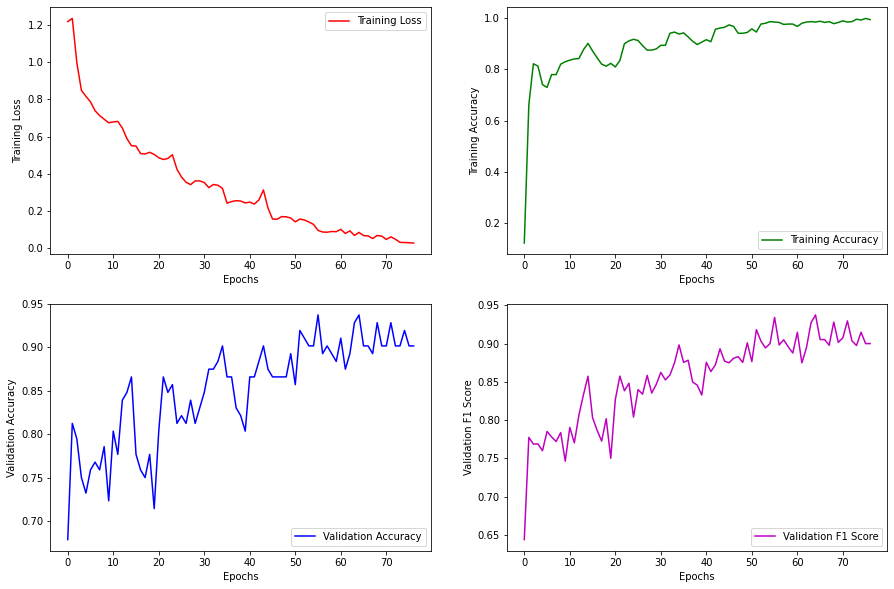

In [28]:
# Plotting graphs - Training Loss, Training Accuracy, Validation accuracy, Validation F-1 score:

fig = plt.figure(figsize=[15,10]) 

plt.subplot(221)
plt.plot(range(num_epochs), train_loss,'r-',label = 'Training Loss') 
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')

plt.subplot(222)
plt.plot(range(num_epochs), train_accuracy,'g-',label = 'Training Accuracy') 
plt.legend(loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')

plt.subplot(223)
plt.plot(range(num_epochs), validation_accuracy, 'b-', label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')

plt.subplot(224)
plt.plot(range(num_epochs), f1_scores, 'm-', label = 'Validation F1 Score')
plt.legend(loc = 'lower right')
plt.xlabel('Epochs')
plt.ylabel('Validation F1 Score')

In [29]:
# Evaluating results on the test set:

correct_pred = 0
f1 = 0
for data in test_loader:
    inputs,labels = data
    if torch.cuda.is_available():
        inputs, labels = inputs.cuda(), labels.cuda()
    
    output = net(inputs) 
    preds = torch.argmax(output,dim=1)
    correct_pred += torch.sum(preds==labels)
    
    labels, preds = labels.cpu().numpy(), preds.cpu().numpy()
    f1 = f1_score(labels, preds, average = 'macro')

test_accuracy = correct_pred.item()/len(test_loader.dataset)
print('Testing accuracy = ' +  str(test_accuracy*100) + ' | ' + 'F1-Score = ' + str(f1))

Testing accuracy = 93.07692307692308 | F1-Score = 0.91
